### Importing required libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import PyQt5
## Uncomment below to open charts in a separate window
# %matplotlib qt 
## Uncomment below to open charts inline with the code
%matplotlib inline

### Importing datasets

In [47]:
sample_data = pd.read_excel('./assets/sample_data.xlsx', sheet_name="set_4")
# set_1 set_2 set_3 set_4 set_5 set_6
# X bar - R chart :: set_1, set_2
# X bar - S chart :: set_1, set_2
# C chart :: set_3
# P chart :: set_4, set_5
# XmR chart :: set_6

### Decision tree to decide on which chart to use

In [48]:
## is data discrete or continuous?
try:
    i = 0
    num_col = len(sample_data.columns) - 1
    flag_conti = True
    while i < num_col:
        if (sample_data[i+1]%1 == 0).all():
            flag_conti = False
        i+=1
    if flag_conti:
        print("Data is continuous")
        ## is there more than one data per subgroup?
        flag_subgroup = False
        num_col = len(sample_data.columns) - 1
        if num_col > 1 :
            flag_subgroup = True
            if num_col > 10:
                print("Data will use 'X bar & S chart'")
            else:
                print("Data will use 'X bar & R chart'")
        else:
            print("Data will use 'XmR chart'")
    else:
        print("Data is discrete")
        ## does data follow Poisson distribution or Binomial
        flag_poisson = False
        mean = round(sample_data[1].mean(),0)
        var = round((sample_data[1].var()),0)
        if(mean == var):
            flag_poisson = True
            print("Data will use 'C chart'") ##left differentiation
        else:
            print("Data will use 'P chart'")
except:
    sample_size_temp = sample_data.columns.values[2]
    print("Data is discrete")
    print("Data will use 'P chart'")

Data is discrete
Data will use 'P chart'


### Plotting the required chart and checking for Anomaly if any

#### X bar - R Chart

X bar Chart:
-->All points within control limits.
R Chart
-->All points within control limits.

From Control Chart Rules:
-->Process is Out of Control


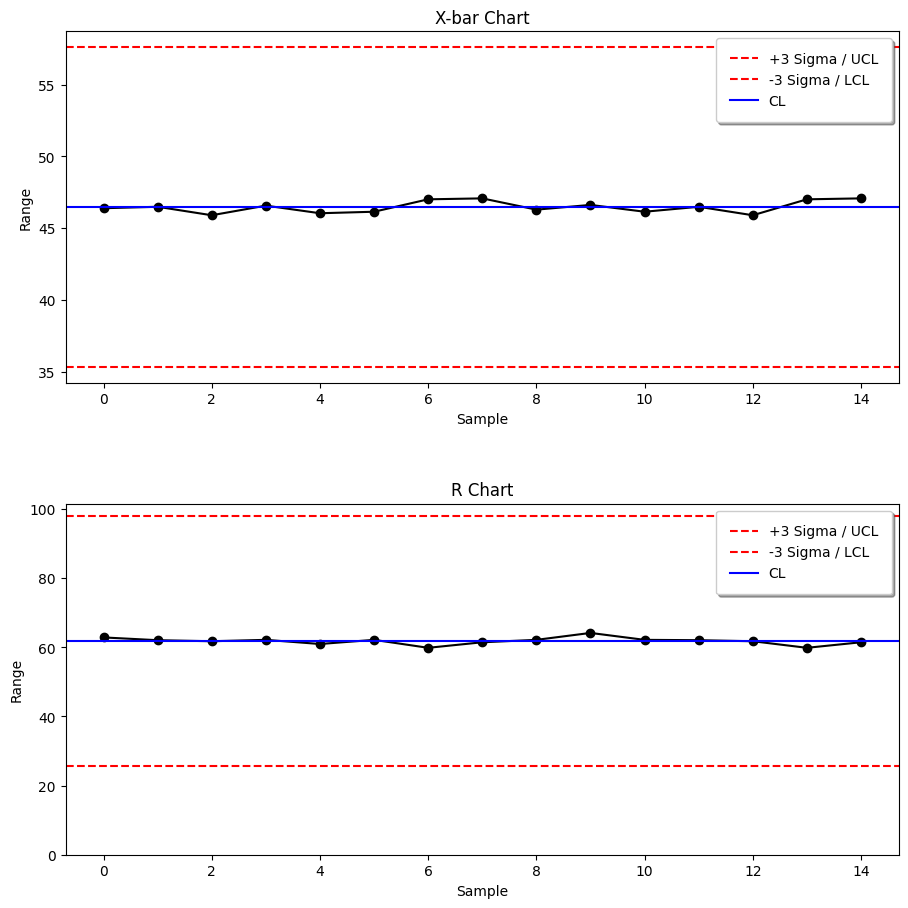

In [39]:
x = np.array(sample_data.iloc[:,1:].to_numpy())  
x_bar = []
r = [] 
for group in x:
    x_bar.append(round(group.mean(),3))
    r.append(round(group.max() - group.min(),3))
fig, axs = plt.subplots(2, figsize=(10,10))
constants = pd.read_excel('./assets/control_charts_constants.xlsx', sheet_name="Sheet1")
sample_size = len(sample_data.columns) - 1
A2 = constants.loc[constants['m'] == sample_size]['A2']
A2 = float(A2)
D4 = constants.loc[constants['m'] == sample_size]['D4']
D4 = float(D4)
D3 = constants.loc[constants['m'] == sample_size]['D3']
D3 = float(D3)
sigma = np.std(x_bar)

## x-bar chart
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((statistics.mean(x_bar)+A2*statistics.mean(r)), color='red', linestyle='dashed', label='+3 Sigma / UCL')
axs[0].axhline((statistics.mean(x_bar)-A2*statistics.mean(r)), color='red', linestyle='dashed', label='-3 Sigma / LCL')
axs[0].axhline((statistics.mean(x_bar)), color='blue', label='CL')
axs[0].set_title('X-bar Chart')
axs[0].set(xlabel='Sample', ylabel='Range')
axs[0].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

## R chart
axs[1].plot(r, linestyle='-', marker='o', color='black')
axs[1].axhline((D4*statistics.mean(r)), color='red', linestyle='dashed', label='+3 Sigma / UCL')
axs[1].axhline((D3*statistics.mean(r)), color='red', linestyle='dashed', label='-3 Sigma / LCL')
axs[1].axhline((statistics.mean(r)), color='blue', label='CL')
axs[1].set_ylim(bottom=0)
axs[1].set_title('R Chart')
axs[1].set(xlabel='Sample', ylabel='Range')
axs[1].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

fig.tight_layout(pad=4)

analysis=""

print("X bar Chart:")
main_arr = axs[0].lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for group in x_bar:
    if group > statistics.mean(x_bar)+A2*statistics.mean(r) or group < statistics.mean(x_bar)-A2*statistics.mean(r):
        num=i+1
        print('-->Sample', i+1, 'out of mean control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

axs[0].scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)    
    
print("R Chart")
main_arr = axs[1].lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for group in r:
    if group > D4*statistics.mean(r):
        print('-->Sample', i+1, 'out of range control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

axs[1].scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)    


length_before=len(x)+1
x=x.flatten()
sample_group = np.repeat(range(1,length_before),sample_size)
df = pd.DataFrame({'data':x, 'sample_group':sample_group})
df_grouped = df.groupby('sample_group').mean()
df_grouped.columns = ['x_bar']
df_max = df.groupby('sample_group').max()
df_min = df.groupby('sample_group').min()
df_grouped['R'] = df_max['data'] - df_min['data']
df_grouped['x_bar_bar'] = statistics.mean(df_grouped['x_bar'])
df_grouped['UCL'] = statistics.mean(df_grouped['x_bar'])+(A2*statistics.mean(df_grouped['R']))
df_grouped['+2s'] = (df_grouped['UCL']-df_grouped['x_bar_bar'])/3*2+df_grouped['x_bar_bar']
df_grouped['+1s'] = (df_grouped['UCL']-df_grouped['x_bar_bar'])/3*1+df_grouped['x_bar_bar']
df_grouped['-1s'] = df_grouped['x_bar_bar']-(df_grouped['UCL']-df_grouped['x_bar_bar'])/3*1
df_grouped['-2s'] = df_grouped['x_bar_bar']- (df_grouped['UCL']-df_grouped['x_bar_bar'])/3*2
df_grouped['LCL'] = statistics.mean(df_grouped['x_bar'])-(A2*statistics.mean(df_grouped['R']))
print("\nFrom Control Chart Rules:")
anomalyDetection(df_grouped)

#### X bar - S Chart

X bar Chart:
-->All points within control limits.
S Chart:
-->All points within control limits.

From Control Chart Rules:
-->Process is Out of Control


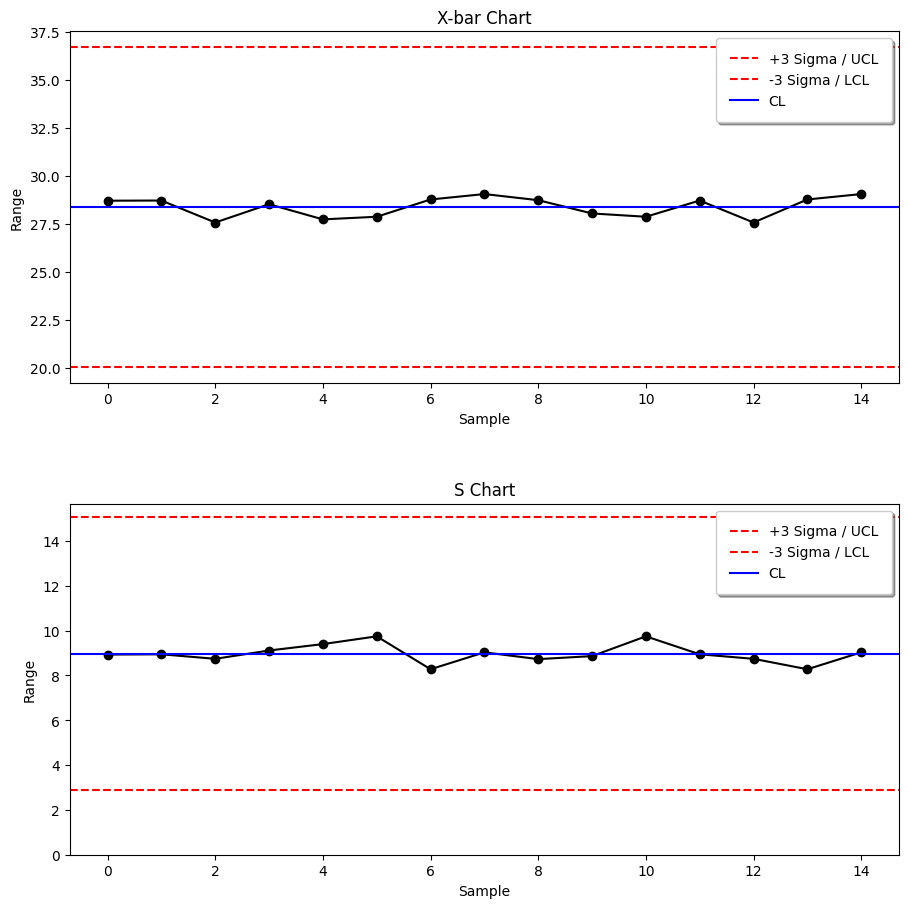

In [43]:
x = np.array(sample_data.iloc[:,1:].to_numpy())  
x_bar = []
s = [] 
for group in x:
    x_bar.append(round(group.mean(),3))
    s.append(round(group.std(),3))
fig, axs = plt.subplots(2, figsize=(10,10))
constants = pd.read_excel('./assets/control_charts_constants.xlsx', sheet_name="Sheet1")
sample_size = len(sample_data.columns) - 1
A3 = constants.loc[constants['m'] == sample_size]['A3']
A3 = float(A3)
B4 = constants.loc[constants['m'] == sample_size]['B4']
B4 = float(B4)
B3 = constants.loc[constants['m'] == sample_size]['B3']
B3 = float(B3)

## x-bar chart
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((statistics.mean(x_bar)+A3*statistics.mean(s)), color='red', linestyle='dashed', label='+3 Sigma / UCL')
axs[0].axhline((statistics.mean(x_bar)-A3*statistics.mean(s)), color='red', linestyle='dashed', label='-3 Sigma / LCL')
axs[0].axhline((statistics.mean(x_bar)), color='blue', label='CL')
axs[0].set_title('X-bar Chart')
axs[0].set(xlabel='Sample', ylabel='Range')
axs[0].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

## S chart
axs[1].plot(s, linestyle='-', marker='o', color='black')
axs[1].axhline((B4*statistics.mean(s)), color='red', linestyle='dashed', label='+3 Sigma / UCL')
axs[1].axhline((B3*statistics.mean(s)), color='red', linestyle='dashed', label='-3 Sigma / LCL')
axs[1].axhline((statistics.mean(s)), color='blue', label='CL')
axs[1].set_ylim(bottom=0)
axs[1].set_title('S Chart')
axs[1].set(xlabel='Sample', ylabel='Range')
axs[1].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

fig.tight_layout(pad=4)

print("X bar Chart:")
main_arr = axs[0].lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for group in x_bar:
    if group > statistics.mean(x_bar)+A3*statistics.mean(s) or group < statistics.mean(x_bar)-A3*statistics.mean(s):
        print('-->Sample', i+1, 'out of mean control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

axs[0].scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)    


print("S Chart:")
main_arr = axs[1].lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for group in s:
    if group > B4*statistics.mean(s) or group < B3*statistics.mean(s):
        print('-->Sample', i+1, 'out of standard deviation control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

axs[1].scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)    

    
length_before=len(x)+1
x=x.flatten()
sample_group = np.repeat(range(1,length_before),sample_size)
df = pd.DataFrame({'data':x, 'sample_group':sample_group})
df_grouped = df.groupby('sample_group').mean()
df_grouped.columns = ['x_bar']
df_grouped['S'] = s
df_grouped['x_bar_bar'] = statistics.mean(df_grouped['x_bar'])
df_grouped['UCL'] = statistics.mean(df_grouped['x_bar'])+(A3*statistics.mean(df_grouped['S']))
df_grouped['+2s'] = (df_grouped['UCL']-df_grouped['x_bar_bar'])/3*2+df_grouped['x_bar_bar']
df_grouped['+1s'] = (df_grouped['UCL']-df_grouped['x_bar_bar'])/3*1+df_grouped['x_bar_bar']
df_grouped['-1s'] = df_grouped['x_bar_bar']-(df_grouped['UCL']-df_grouped['x_bar_bar'])/3*1
df_grouped['-2s'] = df_grouped['x_bar_bar']- (df_grouped['UCL']-df_grouped['x_bar_bar'])/3*2
df_grouped['LCL'] = statistics.mean(df_grouped['x_bar'])-(A3*statistics.mean(df_grouped['S']))
print("\nFrom Control Chart Rules:")
anomalyDetection(df_grouped)

#### C Chart

C Chart:
-->Sample 13 out of defects control limits!

From Control Chart Rules:
-->Process is Out of Control


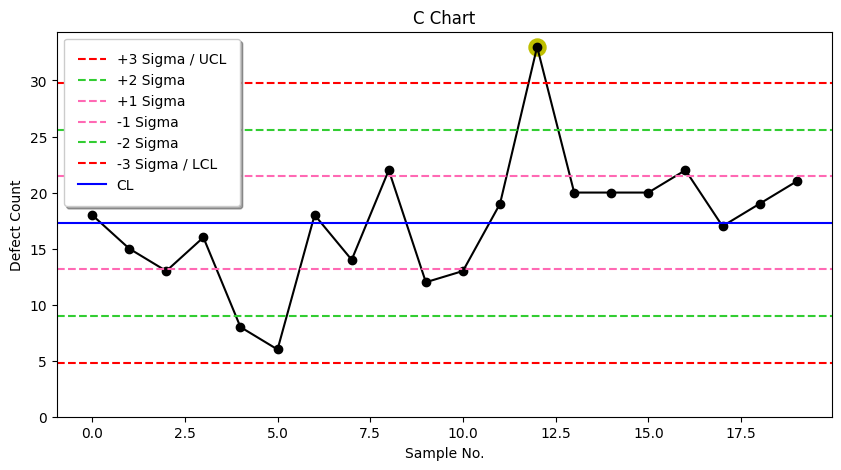

In [34]:
c = sample_data
plt.figure(figsize=(10,5))
plt.plot(c[1], linestyle='-', marker='o', color='black')
plt.axhline(statistics.mean(c[1])+3*np.sqrt(statistics.mean(c[1])), color='red', linestyle='dashed', label='+3 Sigma / UCL')
plt.axhline(statistics.mean(c[1])+2*np.sqrt(statistics.mean(c[1])), color='limegreen', linestyle='dashed', label='+2 Sigma')
plt.axhline(statistics.mean(c[1])+1*np.sqrt(statistics.mean(c[1])), color='hotpink', linestyle='dashed', label='+1 Sigma')
plt.axhline(statistics.mean(c[1])-1*np.sqrt(statistics.mean(c[1])), color='hotpink', linestyle='dashed', label='-1 Sigma')
plt.axhline(statistics.mean(c[1])-2*np.sqrt(statistics.mean(c[1])), color='limegreen', linestyle='dashed', label='-2 Sigma')
plt.axhline(statistics.mean(c[1])-3*np.sqrt(statistics.mean(c[1])), color='red', linestyle='dashed', label='-3 Sigma / LCL')
plt.axhline(statistics.mean(c[1]), color='blue', label='CL')
plt.ylim(bottom=0)
plt.title('C Chart')
plt.xlabel('Sample No.')
plt.ylabel('Defect Count')
plt.legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

print("C Chart:")
ax = plt.gca()
main_arr = ax.lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for group in c[1]:
    if group > statistics.mean(c[1])+3*np.sqrt(statistics.mean(c[1])) or group < statistics.mean(c[1])-3*np.sqrt(statistics.mean(c[1])):
        print('-->Sample', i+1, 'out of defects control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')
    
plt.scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)        
 
c=c[1]
df_grouped = pd.DataFrame()
df_grouped['x_bar']=c
df_grouped.index = np.arange(1, len(df_grouped) + 1)
df_grouped['x_bar_bar'] = statistics.mean(df_grouped['x_bar'])
df_grouped['UCL'] = statistics.mean(df_grouped['x_bar_bar'])+3*np.sqrt(df_grouped['x_bar_bar'])
df_grouped['+2s'] = statistics.mean(df_grouped['x_bar_bar'])+2*np.sqrt(df_grouped['x_bar_bar'])
df_grouped['+1s'] = statistics.mean(df_grouped['x_bar_bar'])+1*np.sqrt(df_grouped['x_bar_bar'])
df_grouped['-1s'] = statistics.mean(df_grouped['x_bar_bar'])-1*np.sqrt(df_grouped['x_bar_bar'])
df_grouped['-2s'] = statistics.mean(df_grouped['x_bar_bar'])-2*np.sqrt(df_grouped['x_bar_bar'])
df_grouped['LCL'] = statistics.mean(df_grouped['x_bar_bar'])-3*np.sqrt(df_grouped['x_bar_bar'])
print("\nFrom Control Chart Rules:")
anomalyDetection(df_grouped)

#### P Chart

P Chart:
-->Sample 13 out of fraction defective control limits!

From Control Chart Rules:
-->Process is Out of Control


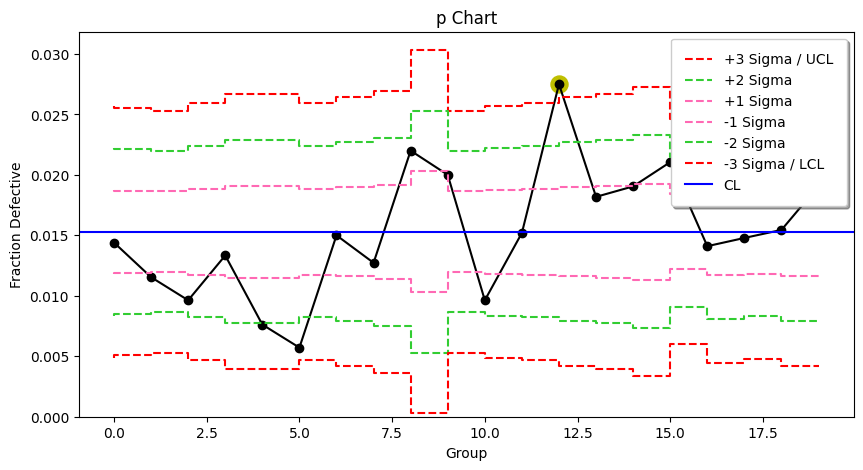

In [36]:
p=sample_data
p['p'] = p[1]/p['sample_size']

# Plot p-chart
plt.figure(figsize=(10,5))
plt.plot(p['p'], linestyle='-', marker='o', color='black')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])+3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='red', linestyle='dashed', label='+3 Sigma / UCL')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])+2*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='limegreen', linestyle='dashed', label='+2 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])+1*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='hotpink', linestyle='dashed', label='+1 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])-1*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='hotpink', linestyle='dashed', label='-1 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])-2*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='limegreen', linestyle='dashed', label='-2 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])-3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='red', linestyle='dashed', label='-3 Sigma / LCL')
plt.axhline(statistics.mean(p['p']), color='blue', label="CL")
plt.ylim(bottom=0)
plt.title('p Chart')
plt.xlabel('Group')
plt.ylabel('Fraction Defective')
plt.legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

print("P Chart:")
ax = plt.gca()
main_arr = ax.lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for group in p['p']:
    if group > (statistics.mean(p['p'])+3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/statistics.mean(p['sample_size'])))) or group < (statistics.mean(p['p'])-3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/statistics.mean(p['sample_size'])))):
        print('-->Sample', i+1, 'out of fraction defective control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')
    
plt.scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)        
    
df_grouped = pd.DataFrame()
df_grouped['x_bar']=p[1]
df_grouped.index = np.arange(1, len(df_grouped) + 1)
df_grouped['x_bar_bar'] = statistics.mean(p['p'])
df_grouped['UCL'] = statistics.mean(p['p'])+3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size'])))
df_grouped['+2s'] = statistics.mean(p['p'])+2*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size'])))
df_grouped['+1s'] = statistics.mean(p['p'])+1*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size'])))
df_grouped['-1s'] = statistics.mean(p['p'])-1*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size'])))
df_grouped['-2s'] = statistics.mean(p['p'])-2*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size'])))
df_grouped['LCL'] = statistics.mean(p['p'])-3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size'])))
print("\nFrom Control Chart Rules:")
anomalyDetection(df_grouped)

#### XmR Chart


X Chart:
-->All points within control limits.
mR Chart:
-->All points within control limits.

From Control Chart Rules:
-->Process is in Control


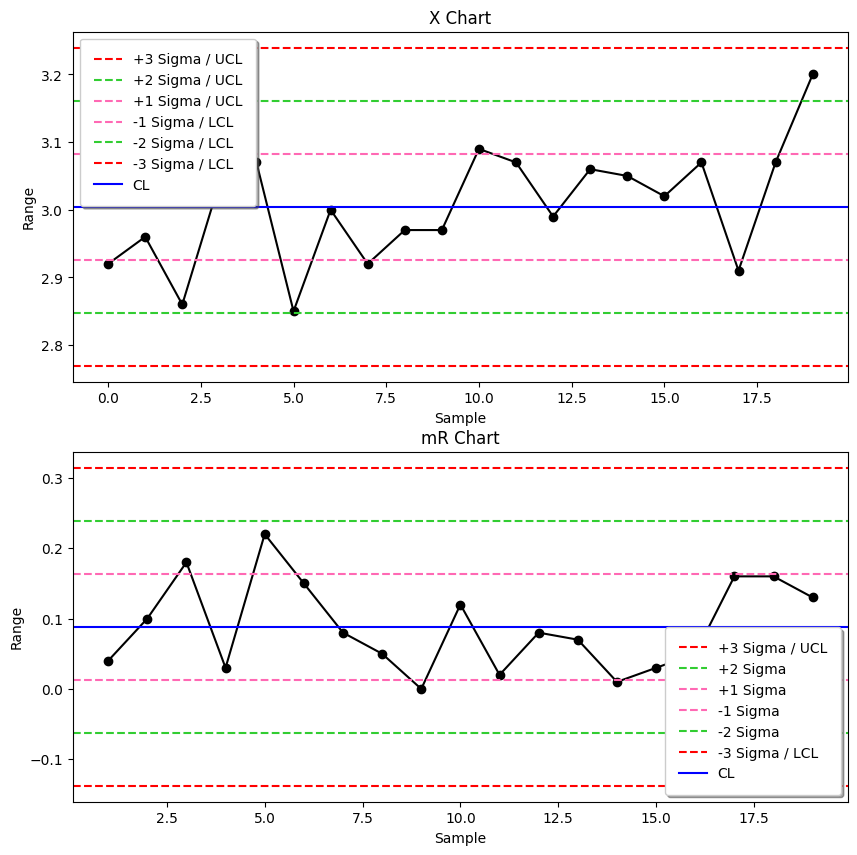

In [39]:
x = np.array(sample_data.iloc[:,1:].to_numpy())
mR=[np.nan]
i = 1
for data in range(1, len(x)):
    mR.append(abs(x[i] - x[i-1]))
    i += 1
mR = pd.Series(mR)
mR=mR.str[0]
x = pd.Series(x.tolist())
x=x.str[0]
data = pd.concat([x,mR], axis=1).rename(columns={0:"x", 1:"mR"})
# plt.figure(figsize=(10,5))
fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].plot(data['x'], linestyle='-', marker='o', color='black')
axs[0].axhline(statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed', label='+3 Sigma / UCL')
axs[0].axhline(statistics.mean(data['x'])+2*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'limegreen', linestyle = 'dashed', label='+2 Sigma / UCL')
axs[0].axhline(statistics.mean(data['x'])+1*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'hotpink', linestyle = 'dashed', label='+1 Sigma / UCL')
axs[0].axhline(statistics.mean(data['x'])-1*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'hotpink', linestyle = 'dashed', label='-1 Sigma / LCL')
axs[0].axhline(statistics.mean(data['x'])-2*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'limegreen', linestyle = 'dashed', label='-2 Sigma / LCL')
axs[0].axhline(statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed', label='-3 Sigma / LCL')
axs[0].axhline(statistics.mean(data['x']), color='blue', label="CL")
axs[0].set_title('X Chart')
axs[0].set(xlabel='Sample',ylabel='Range')
axs[0].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

axs[1].plot(data['mR'], linestyle='-', marker='o', color='black')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed', label='+3 Sigma / UCL')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])+2*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='limegreen', linestyle ='dashed', label='+2 Sigma')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])+1*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='hotpink', linestyle ='dashed', label='+1 Sigma')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])-1*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='hotpink', linestyle ='dashed', label='-1 Sigma')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])-2*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='limegreen', linestyle ='dashed', label='-2 Sigma')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed', label='-3 Sigma / LCL')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])]), color='blue', label="CL")
axs[1].set_title('mR Chart')
axs[1].set(xlabel='Sample',ylabel='Range')
axs[1].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)


print("X Chart:")
main_arr = axs[0].lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for unit in data['x']:
    if unit > statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128 or unit < statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128:
        print('-->Unit', i+1, 'out of control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

axs[0].scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)        


print("mR Chart:")
main_arr = axs[1].lines[0].get_data()
main_arr_df = pd.DataFrame()
main_arr_df['x']=main_arr[0]
main_arr_df['y']=main_arr[1]
scatter_arr_y = []
scatter_arr_x = []
i = 0
control = True
for unit in data['mR']:
    if unit > statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525 or unit < statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525:
        print('-->Unit', i+1, 'out of control limits!')
        scatter_arr_y.append(main_arr_df.iloc[i][1])
        scatter_arr_x.append(main_arr_df.iloc[i][0])
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

axs[1].scatter(scatter_arr_x, scatter_arr_y, marker='o', color='y', s=150)        
    
df_grouped = pd.DataFrame()
df_grouped['x_bar']=data['x']
df_grouped.index = np.arange(1, len(df_grouped) + 1)
df_grouped['x_bar_bar'] = statistics.mean(data['x'])
df_grouped['UCL'] = statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128
df_grouped['+2s'] = statistics.mean(data['x'])+2*statistics.mean(data['mR'][1:len(data['mR'])])/1.128
df_grouped['+1s'] = statistics.mean(data['x'])+1*statistics.mean(data['mR'][1:len(data['mR'])])/1.128
df_grouped['-1s'] = statistics.mean(data['x'])-1*statistics.mean(data['mR'][1:len(data['mR'])])/1.128
df_grouped['-2s'] = statistics.mean(data['x'])-2*statistics.mean(data['mR'][1:len(data['mR'])])/1.128
df_grouped['LCL'] = statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128
print("\nFrom Control Chart Rules:")
anomalyDetection(df_grouped)

# Anomaly Detector Function

In [14]:
def anomalyDetection(df_grouped):    
    # Control chart rules lists setup
    R1_lower = []
    R1_upper = []
    R2_lower = ['-','-']
    R2_upper = ['-','-']
    R3_lower = ['-','-','-','-']
    R3_upper = ['-','-','-','-']
    R4_lower = ['-','-','-','-','-','-']
    R4_upper = ['-','-','-','-','-','-']
    R5_down = ['-','-','-','-','-','-']
    R5_up = ['-','-','-','-','-','-']
    R6 = ['-','-','-','-','-','-','-']
    R7 = ['-','-','-','-','-','-','-','-','-','-','-','-','-','-']
    R8 = ['-','-','-','-','-','-','-','-','-','-','-','-','-']

    # Rule 1 - Lower
    for x in df_grouped['x_bar']:
        if x < df_grouped['LCL'][1]:
            R1_lower.append(False)
        else:
            R1_lower.append(True)

    # Rule 1 - Upper
    for x in df_grouped['x_bar']:
        if x > df_grouped['UCL'][1]:
            R1_upper.append(False)
        else:
            R1_upper.append(True)

    # Rule 2 - Lower
    i = 3
    while i <= len(df_grouped['x_bar']):
        if((df_grouped['x_bar'][i] < df_grouped['-2s'][i] and df_grouped['x_bar'][i-1] < df_grouped['-2s'][i-1]) or 
           (df_grouped['x_bar'][i-1] < df_grouped['-2s'][i-1] and df_grouped['x_bar'][i-2] < df_grouped['-2s'][i-2]) or
           (df_grouped['x_bar'][i] < df_grouped['-2s'][i] and df_grouped['x_bar'][i-2] < df_grouped['-2s'][i-2])):
            R2_lower.append(False)
        else:
            R2_lower.append(True)
        i+=1

    # Rule 2 - Upper
    i = 3
    while i <= len(df_grouped['x_bar']):
        if((df_grouped['x_bar'][i] > df_grouped['+2s'][i] and df_grouped['x_bar'][i-1] > df_grouped['+2s'][i-1]) or
           (df_grouped['x_bar'][i-1] > df_grouped['+2s'][i-1] and df_grouped['x_bar'][i-2] > df_grouped['+2s'][i-2]) or
           (df_grouped['x_bar'][i] > df_grouped['+2s'][i] and df_grouped['x_bar'][i-2] > df_grouped['+2s'][i-2])):
            R2_upper.append(False)
        else:
            R2_upper.append(True)
        i+=1

    # Rule 3 - Lower
    i = 5
    while i <= len(df_grouped['x_bar']):
        if((df_grouped['x_bar'][i-4] < df_grouped['-1s'][i-4] and df_grouped['x_bar'][i-3] < df_grouped['-1s'][i-3] and df_grouped['x_bar'][i-2] < df_grouped['-1s'][i-2] and df_grouped['x_bar'][i-1] < df_grouped['-1s'][i-1]) or
           (df_grouped['x_bar'][i-4] < df_grouped['-1s'][i-4] and df_grouped['x_bar'][i-3] < df_grouped['-1s'][i-3] and df_grouped['x_bar'][i-2] < df_grouped['-1s'][i-2] and df_grouped['x_bar'][i] < df_grouped['-1s'][i]) or
           (df_grouped['x_bar'][i-4] < df_grouped['-1s'][i-4] and df_grouped['x_bar'][i-2] < df_grouped['-1s'][i-2] and df_grouped['x_bar'][i-1] < df_grouped['-1s'][i-1] and df_grouped['x_bar'][i] < df_grouped['-1s'][i]) or
           (df_grouped['x_bar'][i-4] < df_grouped['-1s'][i-4] and df_grouped['x_bar'][i-3] < df_grouped['-1s'][i-3] and df_grouped['x_bar'][i-1] < df_grouped['-1s'][i-1] and df_grouped['x_bar'][i] < df_grouped['-1s'][i]) or
           (df_grouped['x_bar'][i-3] < df_grouped['-1s'][i-3] and df_grouped['x_bar'][i-2] < df_grouped['-1s'][i-2] and df_grouped['x_bar'][i-1] < df_grouped['-1s'][i-1] and df_grouped['x_bar'][i] < df_grouped['-1s'][i])):
            R3_lower.append(False)
        else:
            R3_lower.append(True)
        i+=1

    # Rule 3 - Upper
    i = 5
    while i <= len(df_grouped['x_bar']):
        if((df_grouped['x_bar'][i-4] > df_grouped['+1s'][i-4] and df_grouped['x_bar'][i-3] > df_grouped['+1s'][i-3] and df_grouped['x_bar'][i-2] > df_grouped['+1s'][i-2] and df_grouped['x_bar'][i-1] > df_grouped['+1s'][i-1]) or
           (df_grouped['x_bar'][i-4] > df_grouped['+1s'][i-4] and df_grouped['x_bar'][i-3] > df_grouped['+1s'][i-3] and df_grouped['x_bar'][i-2] > df_grouped['+1s'][i-2] and df_grouped['x_bar'][i] > df_grouped['+1s'][i]) or
           (df_grouped['x_bar'][i-4] > df_grouped['+1s'][i-4] and df_grouped['x_bar'][i-2] > df_grouped['+1s'][i-2] and df_grouped['x_bar'][i-1] > df_grouped['+1s'][i-1] and df_grouped['x_bar'][i] > df_grouped['+1s'][i]) or
           (df_grouped['x_bar'][i-4] > df_grouped['+1s'][i-4] and df_grouped['x_bar'][i-3] > df_grouped['+1s'][i-3] and df_grouped['x_bar'][i-1] > df_grouped['+1s'][i-1] and df_grouped['x_bar'][i] > df_grouped['+1s'][i]) or
           (df_grouped['x_bar'][i-3] > df_grouped['+1s'][i-3] and df_grouped['x_bar'][i-2] > df_grouped['+1s'][i-2] and df_grouped['x_bar'][i-1] > df_grouped['+1s'][i-1] and df_grouped['x_bar'][i] > df_grouped['+1s'][i])):
            R3_upper.append(False)
        else:
            R3_upper.append(True)
        i+=1

    # Rule 4 - Lower
    i = 7
    while i <= len(df_grouped['x_bar']):
        if(df_grouped['x_bar'][i] < df_grouped['x_bar_bar'][i] and
           df_grouped['x_bar'][i-1] < df_grouped['x_bar_bar'][i-1] and
           df_grouped['x_bar'][i-2] < df_grouped['x_bar_bar'][i-2] and
           df_grouped['x_bar'][i-3] < df_grouped['x_bar_bar'][i-3] and
           df_grouped['x_bar'][i-4] < df_grouped['x_bar_bar'][i-4] and
           df_grouped['x_bar'][i-5] < df_grouped['x_bar_bar'][i-5] and
           df_grouped['x_bar'][i-6] < df_grouped['x_bar_bar'][i-6]):
            R4_lower.append(False)
        else:
            R4_lower.append(True)
        i+=1

    # Rule 4 - Upper
    i = 7
    while i <= len(df_grouped['x_bar']):
        if(df_grouped['x_bar'][i] > df_grouped['x_bar_bar'][i] and
           df_grouped['x_bar'][i-1] > df_grouped['x_bar_bar'][i-1] and
           df_grouped['x_bar'][i-2] > df_grouped['x_bar_bar'][i-2] and
           df_grouped['x_bar'][i-3] > df_grouped['x_bar_bar'][i-3] and
           df_grouped['x_bar'][i-4] > df_grouped['x_bar_bar'][i-4] and
           df_grouped['x_bar'][i-5] > df_grouped['x_bar_bar'][i-5] and
           df_grouped['x_bar'][i-6] > df_grouped['x_bar_bar'][i-6]):
            R4_upper.append(False)
        else:
            R4_upper.append(True)
        i+=1

    # Rule 5 - Trend Down
    i = 7
    while i <= len(df_grouped['x_bar']):
        if(df_grouped['x_bar'][i] < df_grouped['x_bar'][i-1] and
          df_grouped['x_bar'][i-1] < df_grouped['x_bar'][i-2] and
          df_grouped['x_bar'][i-2] < df_grouped['x_bar'][i-3] and
          df_grouped['x_bar'][i-3] < df_grouped['x_bar'][i-4] and
          df_grouped['x_bar'][i-4] < df_grouped['x_bar'][i-5] and
          df_grouped['x_bar'][i-5] < df_grouped['x_bar'][i-6]):
            R5_down.append(False)
        else:
            R5_down.append(True)
        i+=1

    # Rule 5 - Trend Up
    i = 7
    while i <= len(df_grouped['x_bar']):
        if(df_grouped['x_bar'][i] > df_grouped['x_bar'][i-1] and
          df_grouped['x_bar'][i-1] > df_grouped['x_bar'][i-2] and
          df_grouped['x_bar'][i-2] > df_grouped['x_bar'][i-3] and
          df_grouped['x_bar'][i-3] > df_grouped['x_bar'][i-4] and
          df_grouped['x_bar'][i-4] > df_grouped['x_bar'][i-5] and
          df_grouped['x_bar'][i-5] > df_grouped['x_bar'][i-6]):
            R5_up.append(False)
        else:
            R5_up.append(True)
        i+=1

    # Rule 6
    i = 8
    while i <= len(df_grouped['x_bar']):
        if((df_grouped['x_bar'][i] < df_grouped['-1s'][i] or df_grouped['x_bar'][i] > df_grouped['+1s'][i]) and
           (df_grouped['x_bar'][i-1] < df_grouped['-1s'][i-1] or df_grouped['x_bar'][i-1] > df_grouped['+1s'][i-1]) and
           (df_grouped['x_bar'][i-2] < df_grouped['-1s'][i-2] or df_grouped['x_bar'][i-2] > df_grouped['+1s'][i-2]) and
           (df_grouped['x_bar'][i-3] < df_grouped['-1s'][i-3] or df_grouped['x_bar'][i-3] > df_grouped['+1s'][i-3]) and
           (df_grouped['x_bar'][i-4] < df_grouped['-1s'][i-4] or df_grouped['x_bar'][i-4] > df_grouped['+1s'][i-4]) and
           (df_grouped['x_bar'][i-5] < df_grouped['-1s'][i-5] or df_grouped['x_bar'][i-5] > df_grouped['+1s'][i-5]) and
           (df_grouped['x_bar'][i-6] < df_grouped['-1s'][i-6] or df_grouped['x_bar'][i-6] > df_grouped['+1s'][i-6]) and
           (df_grouped['x_bar'][i-7] < df_grouped['-1s'][i-7] or df_grouped['x_bar'][i-7] > df_grouped['+1s'][i-7])):
            R6.append(False)
        else:
            R6.append(True)
        i+=1

    # Rule 7
    i = 15
    while i <= len(df_grouped['x_bar']):
        if(((df_grouped['x_bar'][i] < df_grouped['x_bar_bar'][i] and df_grouped['x_bar'][i] > df_grouped['-1s'][i]) or (df_grouped['x_bar'][i] > df_grouped['x_bar_bar'][i] and df_grouped['x_bar'][i] < df_grouped['+1s'][i])) and
           ((df_grouped['x_bar'][i-1] < df_grouped['x_bar_bar'][i-1] and df_grouped['x_bar'][i-1] > df_grouped['-1s'][i-1]) or (df_grouped['x_bar'][i-1] > df_grouped['x_bar_bar'][i-1] and df_grouped['x_bar'][i-1] < df_grouped['+1s'][i-1])) and
           ((df_grouped['x_bar'][i-2] < df_grouped['x_bar_bar'][i-2] and df_grouped['x_bar'][i-2] > df_grouped['-1s'][i-2]) or (df_grouped['x_bar'][i-2] > df_grouped['x_bar_bar'][i-2] and df_grouped['x_bar'][i-2] < df_grouped['+1s'][i-2])) and
           ((df_grouped['x_bar'][i-3] < df_grouped['x_bar_bar'][i-3] and df_grouped['x_bar'][i-3] > df_grouped['-1s'][i-3]) or (df_grouped['x_bar'][i-3] > df_grouped['x_bar_bar'][i-3] and df_grouped['x_bar'][i-3] < df_grouped['+1s'][i-3])) and
           ((df_grouped['x_bar'][i-4] < df_grouped['x_bar_bar'][i-4] and df_grouped['x_bar'][i-4] > df_grouped['-1s'][i-4]) or (df_grouped['x_bar'][i-4] > df_grouped['x_bar_bar'][i-4] and df_grouped['x_bar'][i-4] < df_grouped['+1s'][i-4])) and
           ((df_grouped['x_bar'][i-5] < df_grouped['x_bar_bar'][i-5] and df_grouped['x_bar'][i-5] > df_grouped['-1s'][i-5]) or (df_grouped['x_bar'][i-5] > df_grouped['x_bar_bar'][i-5] and df_grouped['x_bar'][i-5] < df_grouped['+1s'][i-5])) and
           ((df_grouped['x_bar'][i-6] < df_grouped['x_bar_bar'][i-6] and df_grouped['x_bar'][i-6] > df_grouped['-1s'][i-6]) or (df_grouped['x_bar'][i-6] > df_grouped['x_bar_bar'][i-6] and df_grouped['x_bar'][i-6] < df_grouped['+1s'][i-6])) and
           ((df_grouped['x_bar'][i-7] < df_grouped['x_bar_bar'][i-7] and df_grouped['x_bar'][i-7] > df_grouped['-1s'][i-7]) or (df_grouped['x_bar'][i-7] > df_grouped['x_bar_bar'][i-7] and df_grouped['x_bar'][i-7] < df_grouped['+1s'][i-7])) and
           ((df_grouped['x_bar'][i-8] < df_grouped['x_bar_bar'][i-8] and df_grouped['x_bar'][i-8] > df_grouped['-1s'][i-8]) or (df_grouped['x_bar'][i-8] > df_grouped['x_bar_bar'][i-8] and df_grouped['x_bar'][i-8] < df_grouped['+1s'][i-8])) and
           ((df_grouped['x_bar'][i-9] < df_grouped['x_bar_bar'][i-9] and df_grouped['x_bar'][i-9] > df_grouped['-1s'][i-9]) or (df_grouped['x_bar'][i-9] > df_grouped['x_bar_bar'][i-9] and df_grouped['x_bar'][i-9] < df_grouped['+1s'][i-9])) and
           ((df_grouped['x_bar'][i-10] < df_grouped['x_bar_bar'][i-10] and df_grouped['x_bar'][i-10] > df_grouped['-1s'][i-10]) or (df_grouped['x_bar'][i-10] > df_grouped['x_bar_bar'][i-10] and df_grouped['x_bar'][i-10] < df_grouped['+1s'][i-10])) and
           ((df_grouped['x_bar'][i-11] < df_grouped['x_bar_bar'][i-11] and df_grouped['x_bar'][i-11] > df_grouped['-1s'][i-11]) or (df_grouped['x_bar'][i-11] > df_grouped['x_bar_bar'][i-11] and df_grouped['x_bar'][i-11] < df_grouped['+1s'][i-11])) and
           ((df_grouped['x_bar'][i-12] < df_grouped['x_bar_bar'][i-12] and df_grouped['x_bar'][i-12] > df_grouped['-1s'][i-12]) or (df_grouped['x_bar'][i-12] > df_grouped['x_bar_bar'][i-12] and df_grouped['x_bar'][i-12] < df_grouped['+1s'][i-12])) and
           ((df_grouped['x_bar'][i-13] < df_grouped['x_bar_bar'][i-13] and df_grouped['x_bar'][i-13] > df_grouped['-1s'][i-13]) or (df_grouped['x_bar'][i-13] > df_grouped['x_bar_bar'][i-13] and df_grouped['x_bar'][i-13] < df_grouped['+1s'][i-13])) and
           ((df_grouped['x_bar'][i-14] < df_grouped['x_bar_bar'][i-14] and df_grouped['x_bar'][i-14] > df_grouped['-1s'][i-14]) or (df_grouped['x_bar'][i-14] > df_grouped['x_bar_bar'][i-14] and df_grouped['x_bar'][i-14] < df_grouped['+1s'][i-14]))):
            R7.append(False)
        else:
            R7.append(True)
        i+=1

    # Rule #8
    i = 14
    while i <= len(df_grouped['x_bar']):
        if(((df_grouped['x_bar'][i] > df_grouped['x_bar'][i-1]) and
           (df_grouped['x_bar'][i-1] < df_grouped['x_bar'][i-2]) and
           (df_grouped['x_bar'][i-2] > df_grouped['x_bar'][i-3]) and
           (df_grouped['x_bar'][i-3] < df_grouped['x_bar'][i-4]) and
           (df_grouped['x_bar'][i-4] > df_grouped['x_bar'][i-5]) and
           (df_grouped['x_bar'][i-5] < df_grouped['x_bar'][i-6]) and
           (df_grouped['x_bar'][i-6] > df_grouped['x_bar'][i-7]) and
           (df_grouped['x_bar'][i-7] < df_grouped['x_bar'][i-8]) and
           (df_grouped['x_bar'][i-8] > df_grouped['x_bar'][i-9]) and
           (df_grouped['x_bar'][i-9] < df_grouped['x_bar'][i-10]) and
           (df_grouped['x_bar'][i-10] > df_grouped['x_bar'][i-11]) and
           (df_grouped['x_bar'][i-11] < df_grouped['x_bar'][i-12]) and
           (df_grouped['x_bar'][i-12] > df_grouped['x_bar'][i-13])) or
           ((df_grouped['x_bar'][i] < df_grouped['x_bar'][i-1]) and
           (df_grouped['x_bar'][i-1] > df_grouped['x_bar'][i-2]) and
           (df_grouped['x_bar'][i-2] < df_grouped['x_bar'][i-3]) and
           (df_grouped['x_bar'][i-3] > df_grouped['x_bar'][i-4]) and
           (df_grouped['x_bar'][i-4] < df_grouped['x_bar'][i-5]) and
           (df_grouped['x_bar'][i-5] > df_grouped['x_bar'][i-6]) and
           (df_grouped['x_bar'][i-6] < df_grouped['x_bar'][i-7]) and
           (df_grouped['x_bar'][i-7] > df_grouped['x_bar'][i-8]) and
           (df_grouped['x_bar'][i-8] < df_grouped['x_bar'][i-9]) and
           (df_grouped['x_bar'][i-9] > df_grouped['x_bar'][i-10]) and
           (df_grouped['x_bar'][i-10] < df_grouped['x_bar'][i-11]) and
           (df_grouped['x_bar'][i-11] > df_grouped['x_bar'][i-12]) and
           (df_grouped['x_bar'][i-12] < df_grouped['x_bar'][i-13]))):
            R8.append(False)
        else:
            R8.append(True)
        i+=1

    # Define outcomes data frame
    analysis = pd.DataFrame({'R1_lower':R1_lower,
                            'R1_upper':R1_upper,
                            'R2_lower':R2_lower,
                            'R2_upper':R2_upper,
                            'R3_lower':R3_lower,
                            'R3_upper':R3_upper,
                            'R4_lower':R4_lower,
                            'R4_upper':R4_upper,
                            'R5_down':R5_down,
                            'R5_up':R5_up,
                            'R6':R6,
                            'R7':R7,
                            'R8':R8})
    analysis.index = df_grouped.index

    # Look for at least one False value in each of the control chart rules
    control_check=True
    for x in analysis.all() :
        if x==False :
            control_check=False
            break
    if control_check==True :
        print("-->Process is in Control")
    else :
        print("-->Process is Out of Control")